# Crypto-Macro Data Exploratory Analysis

**Data Delta Force - Initial Data Exploration**

This notebook provides comprehensive exploratory data analysis (EDA) of the cryptocurrency and macroeconomic data collected from CoinGecko and FRED APIs.

## Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Cryptocurrency Market Overview](#2-cryptocurrency-market-overview)
3. [Historical Price Analysis](#3-historical-price-analysis)
4. [Macroeconomic Indicators](#4-macroeconomic-indicators)
5. [Correlation Analysis](#5-correlation-analysis)
6. [Time Series Patterns](#6-time-series-patterns)
7. [Data Quality Assessment](#7-data-quality-assessment)
8. [Key Insights & Summary](#8-key-insights--summary)

## 1. Setup & Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import glob
import os

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries imported successfully
Analysis Date: 2025-10-22 18:10


In [2]:
# Define data paths
DATA_DIR = Path('data')
CRYPTO_PRICES_DIR = DATA_DIR / 'raw' / 'crypto' / 'prices'
CRYPTO_MARKET_DIR = DATA_DIR / 'raw' / 'crypto' / 'market_data'
MACRO_DIR = DATA_DIR / 'raw' / 'macro'

print("📂 Data Directory Structure:")
print(f"  Crypto Prices: {CRYPTO_PRICES_DIR}")
print(f"  Crypto Market: {CRYPTO_MARKET_DIR}")
print(f"  Macro Data: {MACRO_DIR}")

📂 Data Directory Structure:
  Crypto Prices: data\raw\crypto\prices
  Crypto Market: data\raw\crypto\market_data
  Macro Data: data\raw\macro


In [3]:
# FIXED: Setup paths - Add this at  start of the path setup cell

import os
from pathlib import Path

# Get the project root directory (go up one level from notebooks/)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Change working directory to project root
os.chdir(PROJECT_ROOT)

print(f"📂 Notebook directory: {NOTEBOOK_DIR}")
print(f"📂 Changed to project root: {PROJECT_ROOT}")

# NOW define the data paths
DATA_DIR = Path('data')
CRYPTO_PRICES_DIR = DATA_DIR / 'raw' / 'crypto' / 'prices'
CRYPTO_MARKET_DIR = DATA_DIR / 'raw' / 'crypto' / 'market_data'
MACRO_DIR = DATA_DIR / 'raw' / 'macro'

# Verify directories exist
print(f"\n📍 Data directory exists: {DATA_DIR.exists()}")
print(f"📍 Crypto prices directory exists: {CRYPTO_PRICES_DIR.exists()}")
print(f"📍 Crypto market directory exists: {CRYPTO_MARKET_DIR.exists()}")
print(f"📍 Macro directory exists: {MACRO_DIR.exists()}")

📂 Notebook directory: c:\Users\rogej\Documents\data-delta-force\notebooks
📂 Changed to project root: c:\Users\rogej\Documents\data-delta-force

📍 Data directory exists: True
📍 Crypto prices directory exists: True
📍 Crypto market directory exists: True
📍 Macro directory exists: True


In [4]:
# Helper function to load the most recent file
def load_latest_file(directory, pattern='*.csv'):
    """Load the most recent CSV file from a directory."""
    files = list(Path(directory).glob(pattern))
    if not files:
        return None
    latest_file = max(files, key=lambda x: x.stat().st_mtime)
    return pd.read_csv(latest_file)

# Helper function to load all files and combine
def load_all_files(directory, pattern='*.csv'):
    """Load and combine all CSV files from a directory."""
    files = list(Path(directory).glob(pattern))
    if not files:
        return None
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs, ignore_index=True)

In [5]:
# Load cryptocurrency market snapshot
market_snapshot = load_latest_file(CRYPTO_MARKET_DIR)

# Load historical prices for each cryptocurrency
crypto_prices = {}
for file in CRYPTO_PRICES_DIR.glob('*_historical_*.csv'):
    coin_name = file.stem.split('_')[1]  # Extract coin name from filename
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    crypto_prices[coin_name] = df

# Load macro data
macro_data = {}
for category in ['interest_rates', 'inflation', 'employment', 'gdp']:
    category_dir = MACRO_DIR / category
    if category_dir.exists():
        for file in category_dir.glob('*.csv'):
            indicator_name = file.stem.split('_')[1]  # Extract indicator name
            df = pd.read_csv(file)
            df['date'] = pd.to_datetime(df['date'])
            macro_data[indicator_name] = df

print("Data loaded successfully")
print(f"\n Loaded Data Summary:")
print(f"  - Market Snapshot: {len(market_snapshot) if market_snapshot is not None else 0} coins")
print(f"  - Historical Prices: {len(crypto_prices)} cryptocurrencies")
print(f"  - Macro Indicators: {len(macro_data)} series")

Data loaded successfully

 Loaded Data Summary:
  - Market Snapshot: 10 coins
  - Historical Prices: 10 cryptocurrencies
  - Macro Indicators: 6 series


## 2. Cryptocurrency Market Overview

In [6]:
# Display market snapshot overview
if market_snapshot is not None:
    print("Current Market Snapshot\n")
    print(f"Data as of: {market_snapshot['timestamp'].iloc[0]}\n")
    
    # Select key columns for display
    display_cols = ['name', 'symbol', 'current_price_usd', 'market_cap_usd', 
                    'market_cap_rank', 'price_change_24h_pct', 'total_volume_usd']
    
    snapshot_display = market_snapshot[display_cols].copy()
    snapshot_display = snapshot_display.sort_values('market_cap_rank')
    
    display(snapshot_display.style.format({
        'current_price_usd': '${:,.2f}',
        'market_cap_usd': '${:,.0f}',
        'price_change_24h_pct': '{:+.2f}%',
        'total_volume_usd': '${:,.0f}'
    }).background_gradient(subset=['price_change_24h_pct'], cmap='RdYlGn', vmin=-10, vmax=10))
else:
    print("No market snapshot data available")

Current Market Snapshot

Data as of: 2025-10-22 14:45:41.860043



,name,symbol,current_price_usd,market_cap_usd,market_cap_rank,price_change_24h_pct,total_volume_usd
0,Bitcoin,btc,"$107,824.00","$2,151,830,590,262",1.000000,-1.93%,"$111,119,819,466"
1,Ethereum,eth,"$3,801.57","$459,654,338,436",2.000000,-3.26%,"$47,336,138,147"
2,Tether,usdt,$1.00,"$182,506,221,727",3.000000,-0.01%,"$167,597,597,219"
3,BNB,bnb,"$1,072.27","$148,785,190,782",4.000000,-1.19%,"$2,906,501,272"
4,XRP,xrp,$2.39,"$143,085,129,140",5.000000,-2.44%,"$4,710,859,623"
5,Solana,sol,$183.04,"$100,068,635,317",6.000000,-3.15%,"$8,482,918,187"
6,Dogecoin,doge,$0.19,"$28,756,346,798",10.000000,-4.34%,"$2,768,275,996"
7,Cardano,ada,$0.63,"$23,131,359,836",11.000000,-4.11%,"$1,400,718,284"
8,Polkadot,dot,$2.98,"$4,530,320,047",40.000000,-3.12%,"$286,676,809"
9,MATIC (migrated to POL),matic,$nan,$nan,nan,+nan%,"$115,729"



 Market Statistics

Total Market Cap (Top 9): $3,242,348,132,345
Total 24h Volume: $346,609,505,003
Average 24h Price Change: -2.62%

Bitcoin Dominance: 66.37%


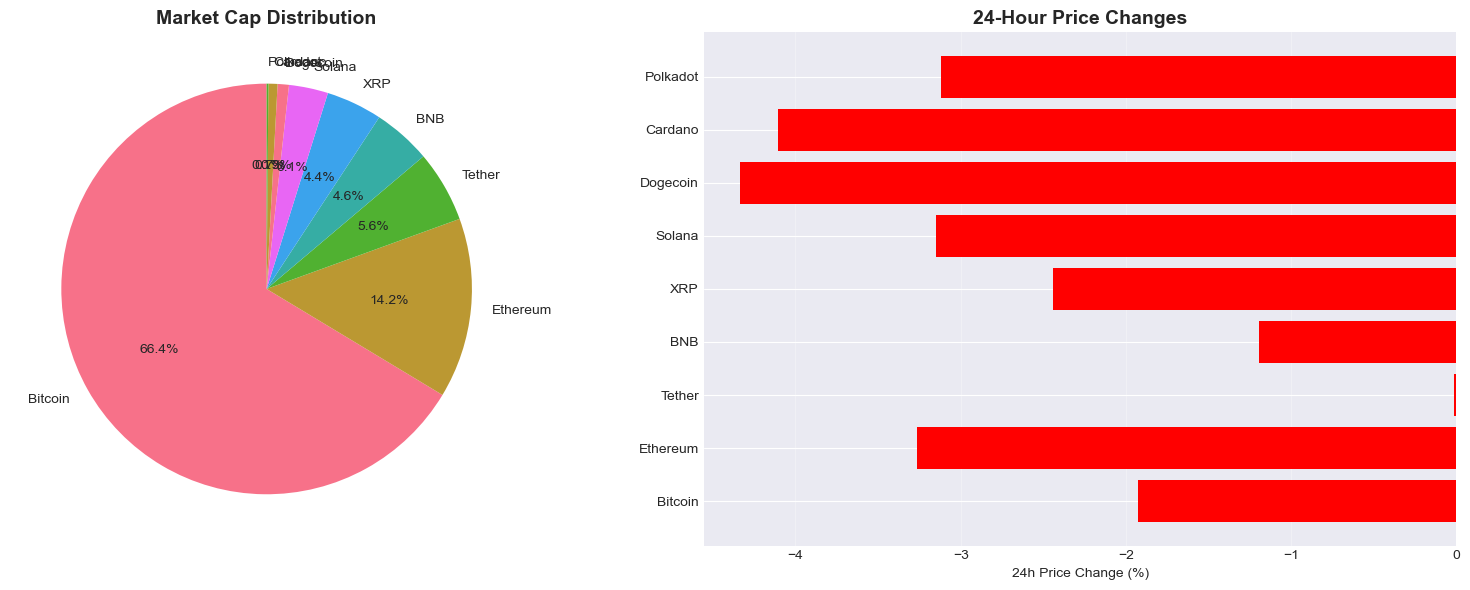

In [9]:
# Market statistics - FIXED
if market_snapshot is not None:
    # Filter out rows with NaN values (like migrated MATIC token)
    valid_data = market_snapshot[market_snapshot['market_cap_usd'].notna()].copy()
    
    if len(valid_data) > 0:
        print("\n Market Statistics\n")
        
        total_market_cap = valid_data['market_cap_usd'].sum()
        total_volume = valid_data['total_volume_usd'].sum()
        avg_price_change = valid_data['price_change_24h_pct'].mean()
        
        print(f"Total Market Cap (Top {len(valid_data)}): ${total_market_cap:,.0f}")
        print(f"Total 24h Volume: ${total_volume:,.0f}")
        print(f"Average 24h Price Change: {avg_price_change:+.2f}%")
        
        # Bitcoin dominance
        btc_data = valid_data[valid_data['symbol']=='btc']
        if len(btc_data) > 0:
            btc_dominance = (btc_data['market_cap_usd'].values[0] / total_market_cap * 100)
            print(f"\nBitcoin Dominance: {btc_dominance:.2f}%")
        
        # Market cap distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Pie chart of market cap
        market_snapshot_sorted = valid_data.sort_values('market_cap_usd', ascending=False)
        ax1.pie(market_snapshot_sorted['market_cap_usd'],
                labels=market_snapshot_sorted['name'],
                autopct='%1.1f%%',
                startangle=90)
        ax1.set_title('Market Cap Distribution', fontsize=14, fontweight='bold')
        
        # Bar chart of 24h price changes
        colors = ['green' if x > 0 else 'red' for x in market_snapshot_sorted['price_change_24h_pct']]
        ax2.barh(market_snapshot_sorted['name'], market_snapshot_sorted['price_change_24h_pct'], color=colors)
        ax2.set_xlabel('24h Price Change (%)')
        ax2.set_title('24-Hour Price Changes', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid market data available")

## 3. Historical Price Analysis

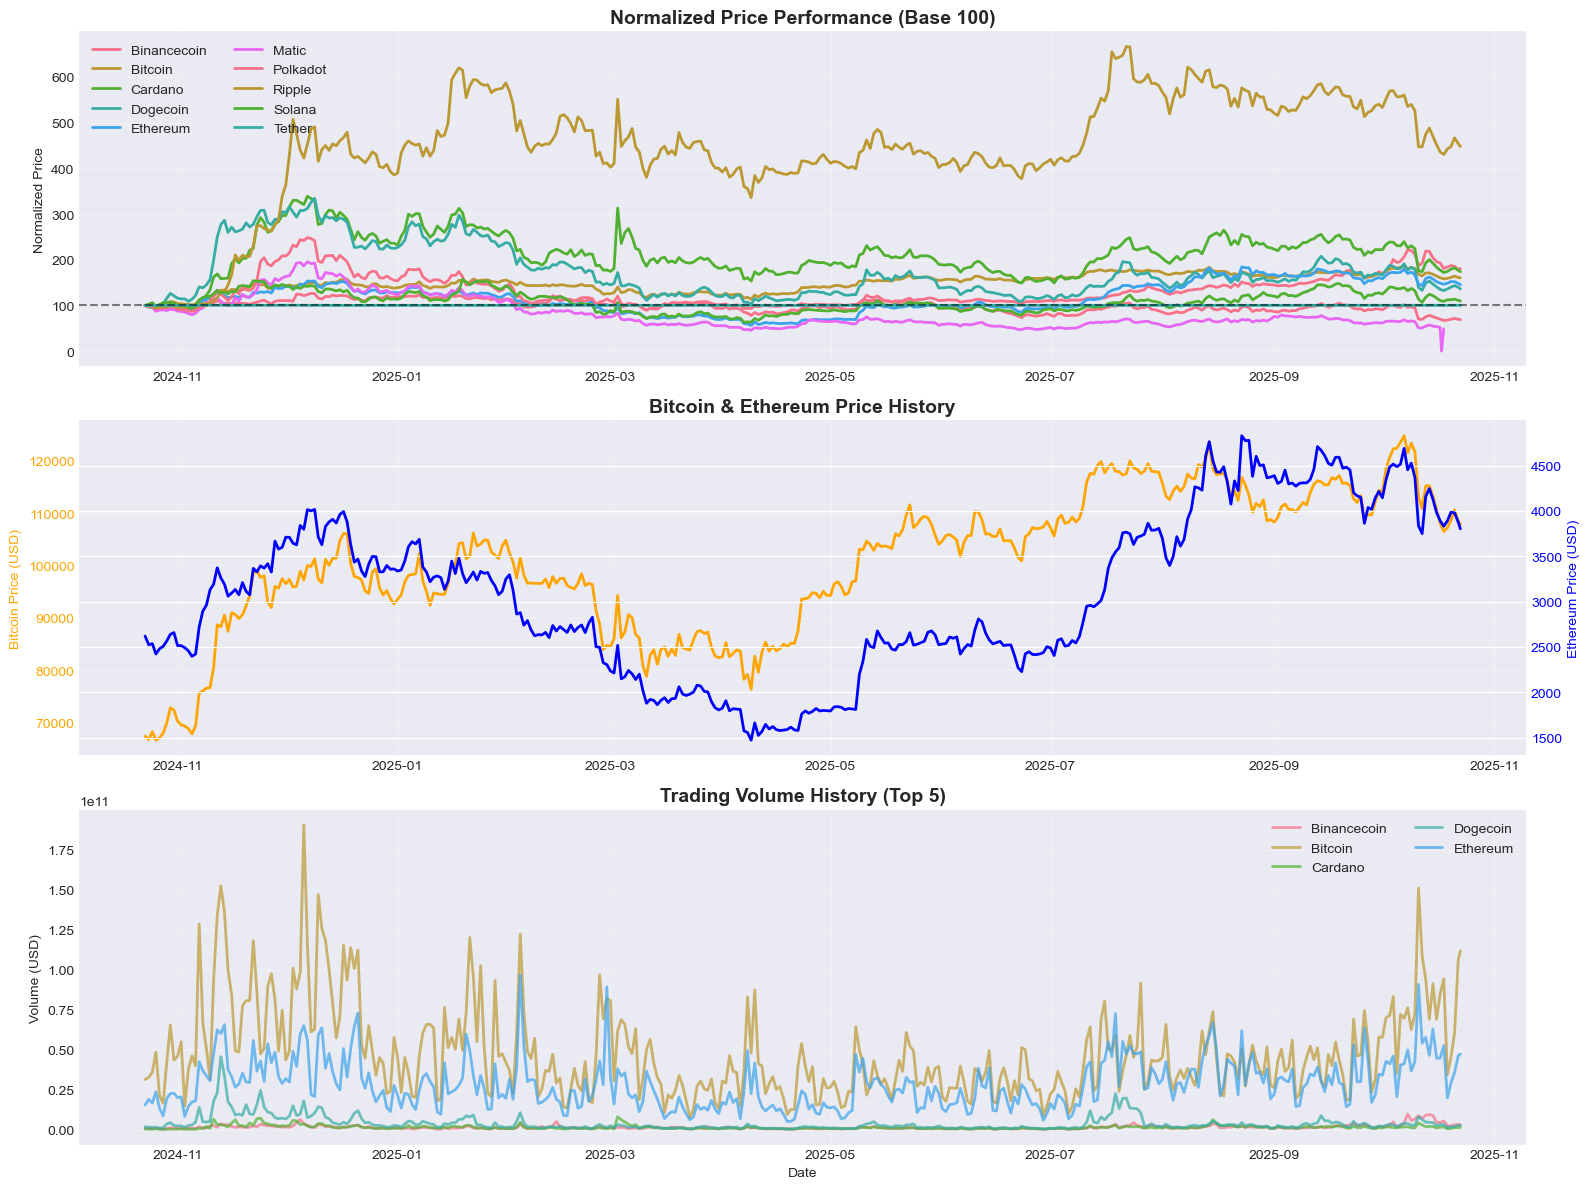

In [ ]:
# Price trends over time
if crypto_prices:
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Normalized prices (all start at 100)
    ax1 = axes[0]
    for coin, df in crypto_prices.items():
        normalized = (df['price'] / df['price'].iloc[0]) * 100
        ax1.plot(df['timestamp'], normalized, label=coin.replace('-', ' ').title(), linewidth=2)
    
    ax1.set_title('Normalized Price Performance (Base 100)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Normalized Price')
    ax1.legend(loc='best', ncol=2)
    ax1.grid(alpha=0.3)
    ax1.axhline(y=100, color='black', linestyle='--', alpha=0.5)
    
    # Plot 2: Bitcoin and Ethereum absolute prices
    ax2 = axes[1]
    if 'bitcoin' in crypto_prices:
        ax2.plot(crypto_prices['bitcoin']['timestamp'], 
                crypto_prices['bitcoin']['price'], 
                label='Bitcoin', linewidth=2, color='orange')
        ax2.set_ylabel('Bitcoin Price (USD)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
    
    if 'ethereum' in crypto_prices:
        ax2_right = ax2.twinx()
        ax2_right.plot(crypto_prices['ethereum']['timestamp'], 
                      crypto_prices['ethereum']['price'], 
                      label='Ethereum', linewidth=2, color='blue')
        ax2_right.set_ylabel('Ethereum Price (USD)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')
    
    ax2.set_title('Bitcoin & Ethereum Price History', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # Plot 3: Trading volumes
    ax3 = axes[2]
    for coin, df in list(crypto_prices.items())[:5]:  # Top 5 by volume
        ax3.plot(df['timestamp'], df['total_volume'], 
                label=coin.replace('-', ' ').title(), linewidth=2, alpha=0.7)
    
    ax3.set_title('Trading Volume History (Top 5)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Volume (USD)')
    ax3.legend(loc='best', ncol=2)
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No historical price data available")

In [11]:
# Price statistics summary
if crypto_prices:
    print(" Historical Price Statistics (365 Days)\n")
    
    stats_data = []
    for coin, df in crypto_prices.items():
        stats_data.append({
            'Cryptocurrency': coin.replace('-', ' ').title(),
            'Current Price': df['price'].iloc[-1],
            'Min Price': df['price'].min(),
            'Max Price': df['price'].max(),
            'Avg Price': df['price'].mean(),
            'Std Dev': df['price'].std(),
            'Return (%)': ((df['price'].iloc[-1] / df['price'].iloc[0]) - 1) * 100,
            'Volatility (%)': (df['price'].std() / df['price'].mean()) * 100
        })
    
    stats_df = pd.DataFrame(stats_data).sort_values('Return (%)', ascending=False)
    
    display(stats_df.style.format({
        'Current Price': '${:,.2f}',
        'Min Price': '${:,.2f}',
        'Max Price': '${:,.2f}',
        'Avg Price': '${:,.2f}',
        'Std Dev': '${:,.2f}',
        'Return (%)': '{:+.2f}%',
        'Volatility (%)': '{:.2f}%'
    }).background_gradient(subset=['Return (%)'], cmap='RdYlGn'))

 Historical Price Statistics (365 Days)



,Cryptocurrency,Current Price,Min Price,Max Price,Avg Price,Std Dev,Return (%),Volatility (%)
7,Ripple,$2.39,$0.50,$3.56,$2.37,$0.65,+347.69%,27.61%
0,Binancecoin,"$1,072.27",$532.57,"$1,311.71",$719.06,$154.28,+80.74%,21.46%
2,Cardano,$0.63,$0.32,$1.23,$0.77,$0.17,+73.76%,22.64%
1,Bitcoin,"$107,876.86","$66,585.67","$124,773.51","$100,498.79","$13,097.32",+60.17%,13.03%
4,Ethereum,"$3,801.85","$1,471.36","$4,829.23","$3,076.16",$880.14,+45.13%,28.61%
3,Dogecoin,$0.19,$0.13,$0.47,$0.24,$0.08,+36.03%,32.52%
8,Solana,$183.04,$105.49,$262.56,$182.03,$36.22,+9.46%,19.90%
9,Tether,$1.00,$1.00,$1.00,$1.00,$0.00,+0.10%,0.06%
6,Polkadot,$2.98,$2.89,$10.73,$4.84,$1.58,-31.12%,32.72%
5,Matic,$0.18,$0.00,$0.72,$0.30,$0.13,-51.48%,41.99%


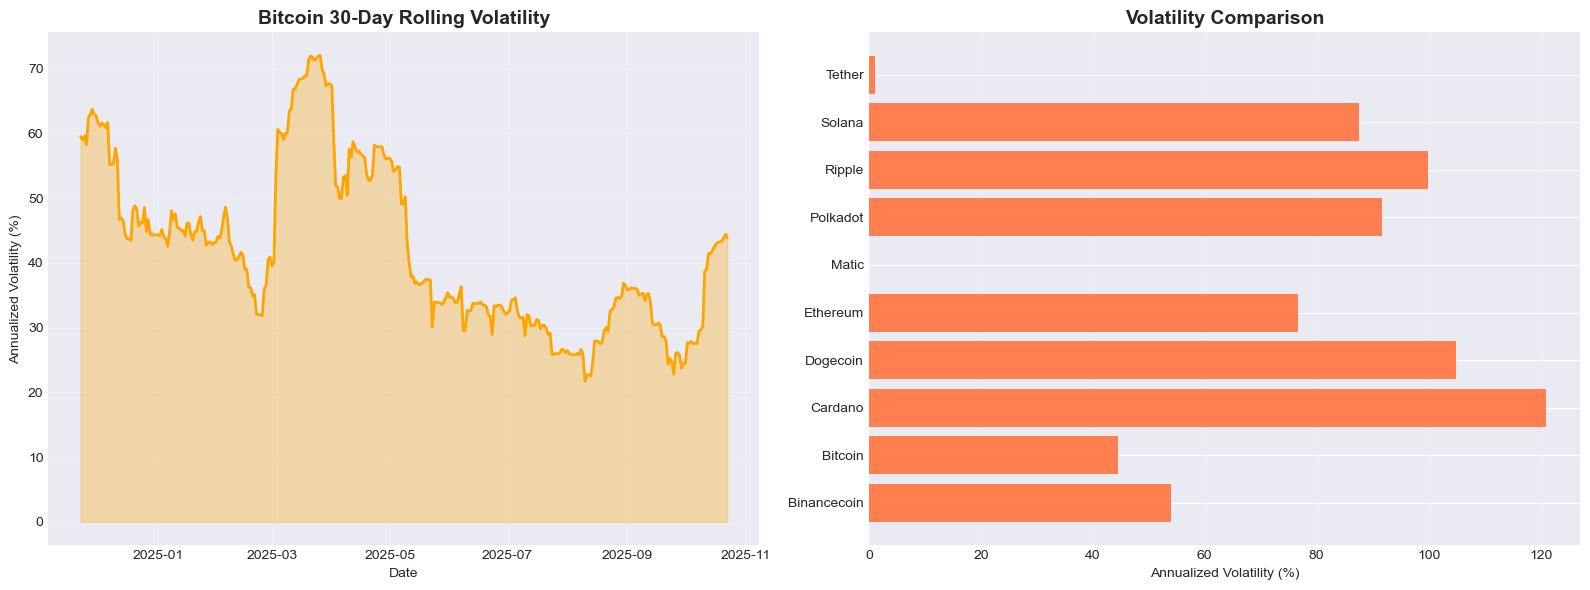

In [12]:
# Volatility analysis
if crypto_prices:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calculate 30-day rolling volatility for Bitcoin
    if 'bitcoin' in crypto_prices:
        btc = crypto_prices['bitcoin'].copy()
        btc['returns'] = btc['price'].pct_change()
        btc['volatility_30d'] = btc['returns'].rolling(window=30).std() * np.sqrt(365) * 100
        
        ax1.plot(btc['timestamp'], btc['volatility_30d'], linewidth=2, color='orange')
        ax1.fill_between(btc['timestamp'], btc['volatility_30d'], alpha=0.3, color='orange')
        ax1.set_title('Bitcoin 30-Day Rolling Volatility', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Annualized Volatility (%)')
        ax1.grid(alpha=0.3)
    
    # Volatility comparison across all coins
    volatilities = []
    names = []
    for coin, df in crypto_prices.items():
        returns = df['price'].pct_change()
        vol = returns.std() * np.sqrt(365) * 100
        volatilities.append(vol)
        names.append(coin.replace('-', ' ').title())
    
    ax2.barh(names, volatilities, color='coral')
    ax2.set_xlabel('Annualized Volatility (%)')
    ax2.set_title('Volatility Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Macroeconomic Indicators

In [13]:
# Display available macro indicators
if macro_data:
    print("Available Macroeconomic Indicators:\n")
    
    for name, df in macro_data.items():
        print(f"  • {name.replace('_', ' ').title()}: {len(df)} observations")
        print(f"    Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"    Latest value: {df['value'].iloc[-1]:.2f}\n")
else:
    print("No macro data available")

Available Macroeconomic Indicators:

  • 10Y: 21 observations
    Date range: 2025-09-22 00:00:00 to 2025-10-20 00:00:00
    Latest value: 4.00

  • 2Y: 21 observations
    Date range: 2025-09-22 00:00:00 to 2025-10-20 00:00:00
    Latest value: 3.46

  • Fed: 29 observations
    Date range: 2025-09-22 00:00:00 to 2025-10-20 00:00:00
    Latest value: 4.11

  • Cpi: 68 observations
    Date range: 2020-01-01 00:00:00 to 2025-08-01 00:00:00
    Latest value: 323.36

  • Unemployment: 68 observations
    Date range: 2020-01-01 00:00:00 to 2025-08-01 00:00:00
    Latest value: 4.30

  • Gdp: 22 observations
    Date range: 2020-01-01 00:00:00 to 2025-04-01 00:00:00
    Latest value: 30485.73



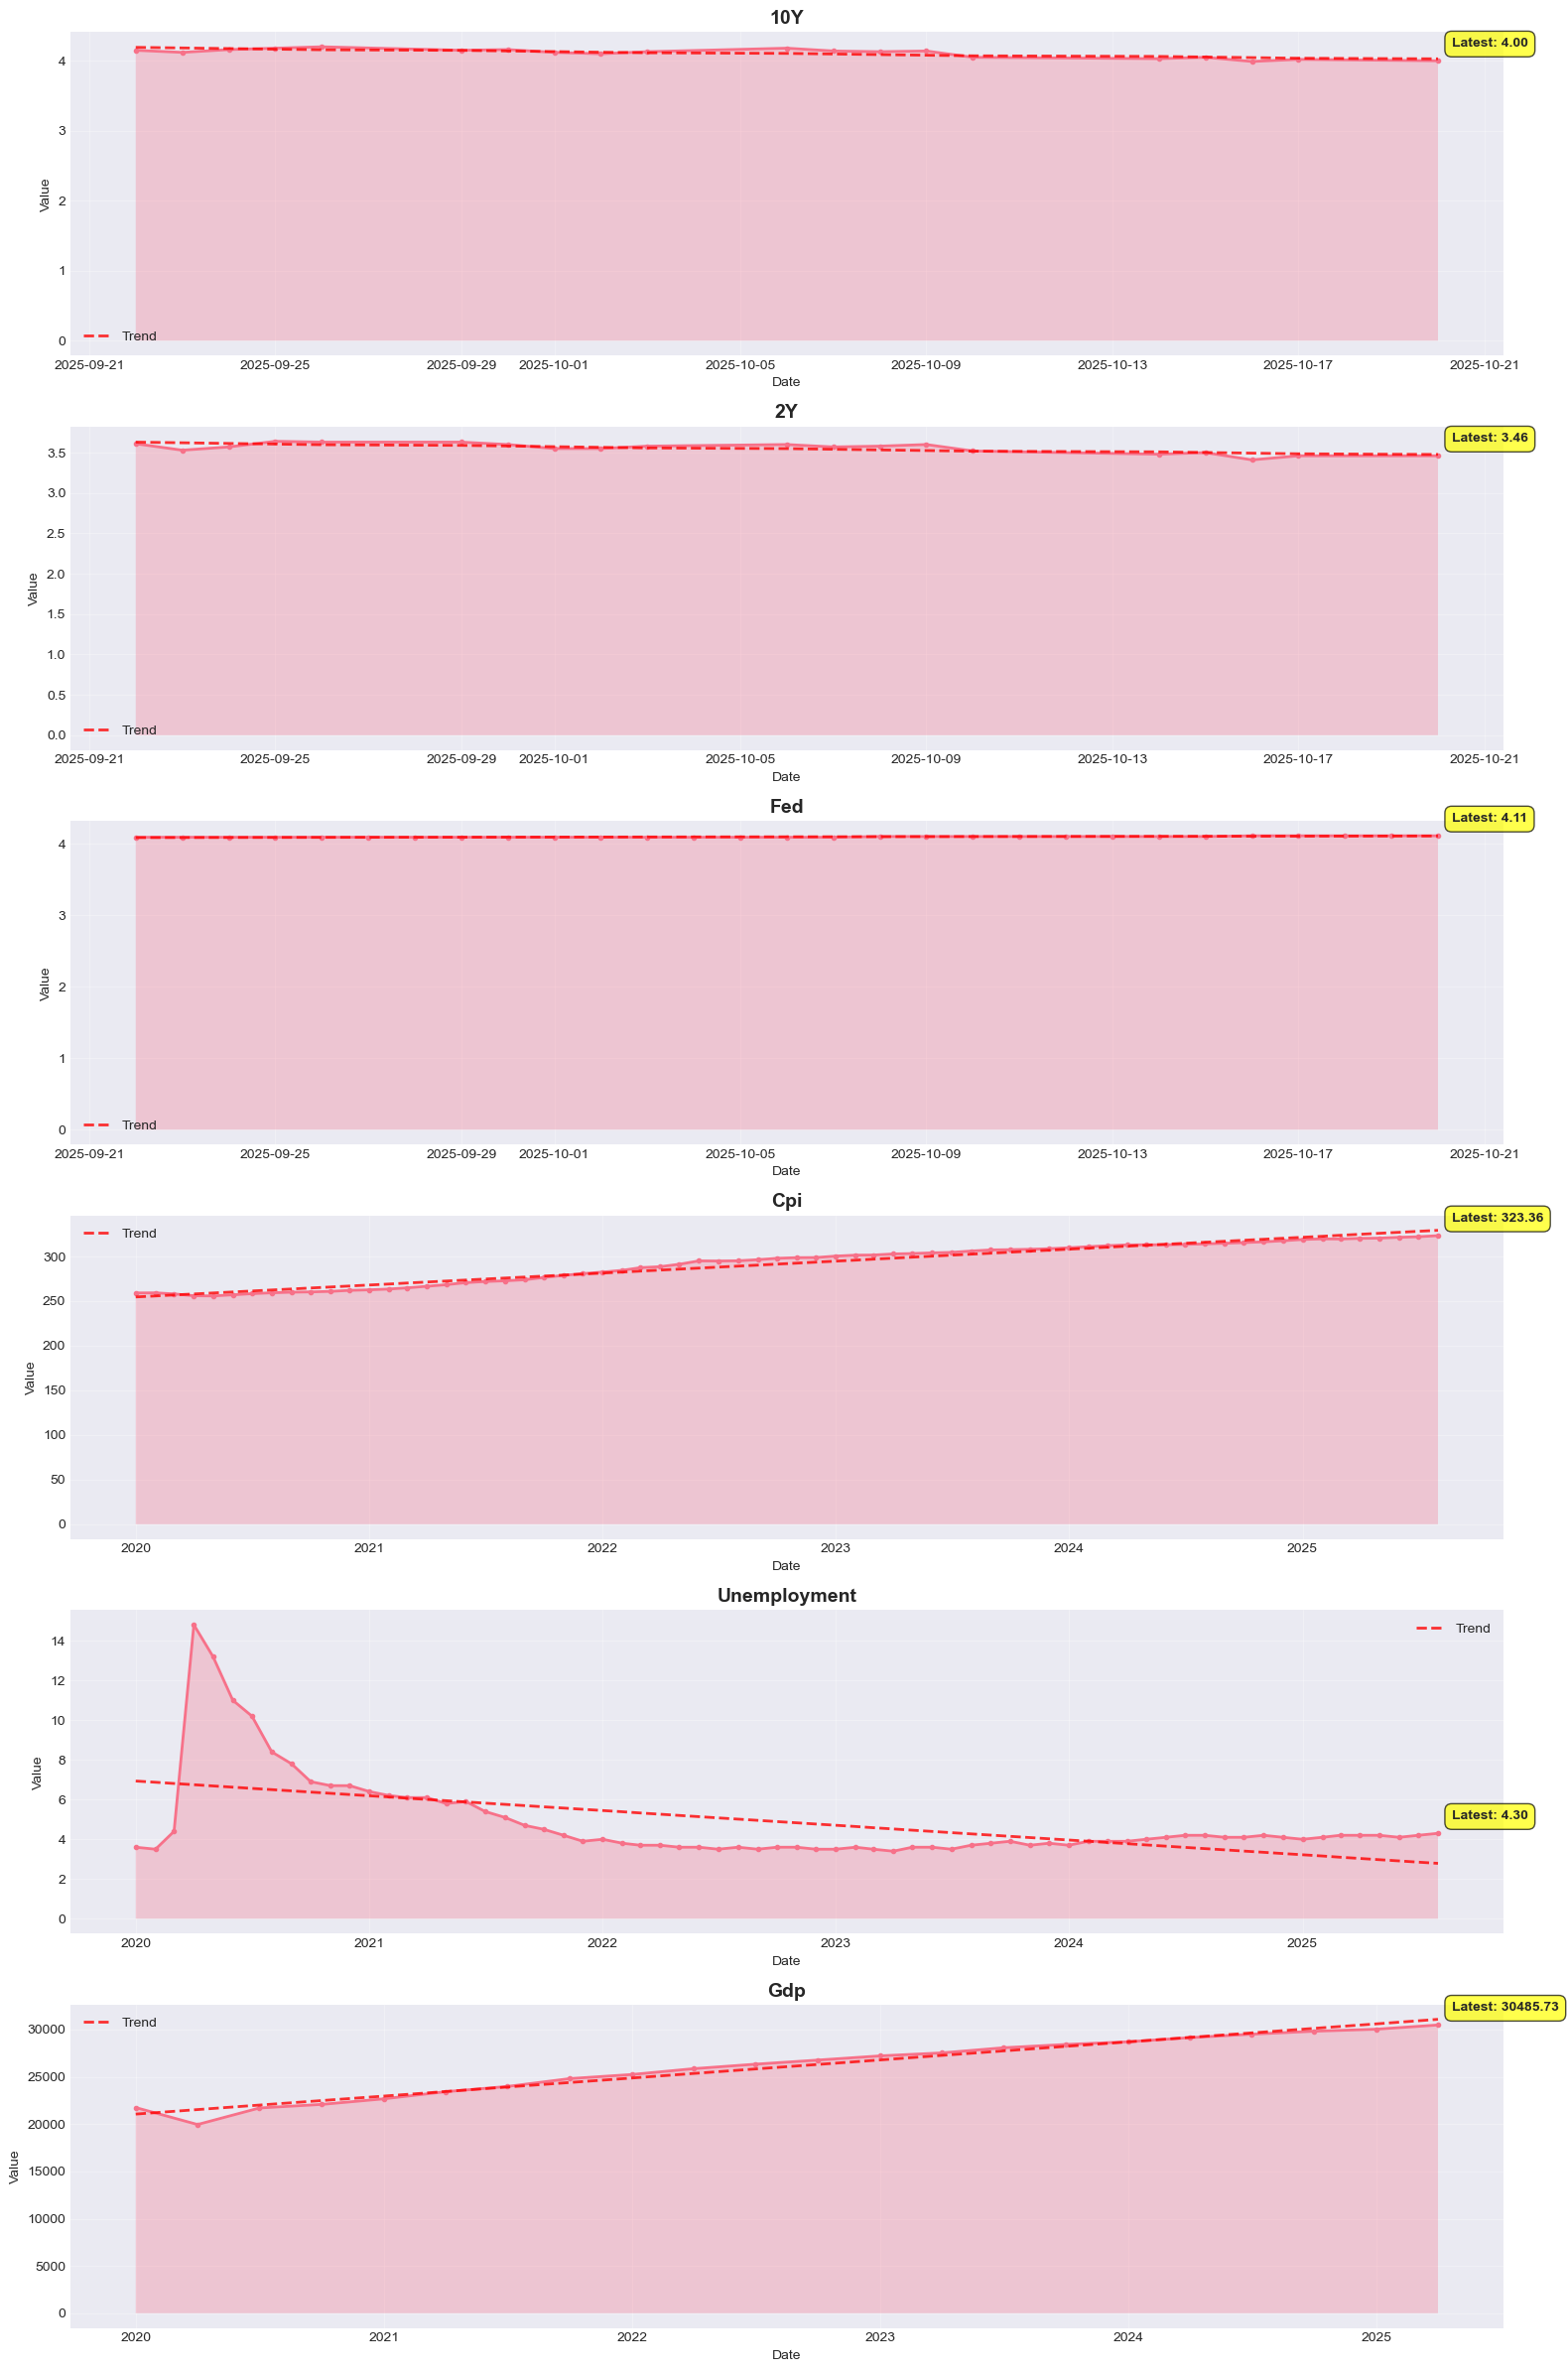

In [16]:
# Plot macro indicators - FIXED
if macro_data:
    n_indicators = len(macro_data)
    fig, axes = plt.subplots(n_indicators, 1, figsize=(16, 4*n_indicators))
    
    if n_indicators == 1:
        axes = [axes]
    
    for ax, (name, df) in zip(axes, macro_data.items()):
        # Filter out NaN values
        df_clean = df.dropna(subset=['value'])
        
        if len(df_clean) > 0:
            # Plot the time series
            ax.plot(df_clean['date'], df_clean['value'], linewidth=2, marker='o', markersize=3)
            ax.fill_between(df_clean['date'], df_clean['value'], alpha=0.3)
            
            # Add trend line only if we have enough data points
            if len(df_clean) >= 2:
                try:
                    z = np.polyfit(range(len(df_clean)), df_clean['value'].values, 1)
                    p = np.poly1d(z)
                    ax.plot(df_clean['date'], p(range(len(df_clean))), "r--", alpha=0.8, linewidth=2, label='Trend')
                except np.linalg.LinAlgError:
                    # Skip trend line if calculation fails
                    pass
            
            ax.set_title(f"{name.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
            ax.set_xlabel('Date')
            ax.set_ylabel('Value')
            ax.grid(alpha=0.3)
            ax.legend()
            
            # Add latest value annotation
            latest_val = df_clean['value'].iloc[-1]
            latest_date = df_clean['date'].iloc[-1]
            ax.annotate(f'Latest: {latest_val:.2f}',
                       xy=(latest_date, latest_val),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                       fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Macro indicator statistics
if macro_data:
    print("\n Macroeconomic Indicator Statistics\n")
    
    macro_stats = []
    for name, df in macro_data.items():
        macro_stats.append({
            'Indicator': name.replace('_', ' ').title(),
            'Current': df['value'].iloc[-1],
            'Min': df['value'].min(),
            'Max': df['value'].max(),
            'Mean': df['value'].mean(),
            'Std Dev': df['value'].std(),
            'Change (%)': ((df['value'].iloc[-1] / df['value'].iloc[0]) - 1) * 100 if df['value'].iloc[0] != 0 else np.nan
        })
    
    macro_stats_df = pd.DataFrame(macro_stats)
    display(macro_stats_df.style.format({
        'Current': '{:.2f}',
        'Min': '{:.2f}',
        'Max': '{:.2f}',
        'Mean': '{:.2f}',
        'Std Dev': '{:.2f}',
        'Change (%)': '{:+.2f}%'
    }))


📊 Macroeconomic Indicator Statistics



,Indicator,Current,Min,Max,Mean,Std Dev,Change (%)
0,10Y,4.00,3.99,4.20,4.11,0.06,-3.61%
1,2Y,3.46,3.41,3.64,3.55,0.06,-4.16%
2,Fed,4.11,4.09,4.11,4.10,0.01,+0.49%
3,Cpi,323.36,255.80,323.36,292.01,22.41,+24.79%
4,Unemployment,4.30,3.40,14.80,4.86,2.22,+19.44%
5,Gdp,30485.73,19958.29,30485.73,26072.19,3141.73,+40.16%
